# Amex - Model Part


This is a starter code template for model tuning 

##### DDL: 7.21(Meet on 7.14)
##### Deliverables: code(shown above)

Data Address: https://www.kaggle.com/datasets/hongyishao/amexshycombinedfeatures

#### Explaination:
- '../input/amexshycombinedfeatures/trainRFCVSelected.pkl' -> Final combined Data with 600 features
- '../input/amexshycombinedfeatures/trainKsSelected.pkl' -> Use KS to select from 1299 to 800
- '../input/amexshycombinedfeatures/trainClean.pkl' -> Just combine and clean without selection

Features' Dictionary: https://docs.google.com/spreadsheets/d/1UsodGz_lkmzVmvweA_0YZZwRoB2VBpdAVuEuPtb38wI/edit?usp=sharing

### Details

- Hongyi: XGBOOST,CATBOOST MODEL TUNING + MODEL STACKING
- Delivables: Model performance in Excel sheet, a stacking function


- Duanmu: MODEL BLENDING METHOD RESEARCH(RANK,WEIGHT,...)
- Delivables: A blending function and improved performance better than the records in Excel Sheet


- Ziyi: LR,SVM,BAYES,RF,LIGHTGBM MODEL TUNING
- Delivables: Model performance in Excel sheet


- Haobo: TUNING NN MODELS PARAMETERS
- Delivables: NN code + performance record


In [1]:
import numpy as np
import pandas as pd
import os

import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import sklearn

In [2]:
train = pd.read_pickle('../input/amexshycombinedfeatures/train.pkl')
trainY = pd.read_pickle('../input/amexshycombinedfeatures/trainY.pkl')

In [3]:
train.columns = [f'f_{_}' for _ in range(0,train.shape[1])]
for i in train.columns:
    if train[i].dtypes == 'object':
        train[i]=train[i].apply(lambda x: hash(str(x))%997)
import pickle
with open('../input/amexshycombinedfeatures/selected1.pickle', 'rb') as file:    
    selected1 = pickle.load(file)    
with open('../input/amexshycombinedfeatures/selected2.pickle', 'rb') as file:    
    selected2 = pickle.load(file)    
with open('../input/amexshycombinedfeatures/selected3.pickle', 'rb') as file:    
    selected3 = pickle.load(file)    
columns = []
for i,j,k,l in zip(train.columns,selected1,selected2,selected3):
    if j == k == l == True:
        columns.append(i)
train = train[columns]
gc.collect()

0

In [4]:
# model robustness indicator
def calc_vdr(pred, actual, vdr_cutoff = 0.2):
    # Function to calculate VDR at a given cutoff

    df_vdr_train = pd.DataFrame(zip(pred), columns = ['predicted_proba'])
    df_vdr_train['actual'] = np.array(actual)
    df_vdr_train = df_vdr_train.sort_values(by = 'predicted_proba', ascending = False)
    num_bad = df_vdr_train['actual'].sum()
    top_20_pct = int(len(df_vdr_train['actual'])*vdr_cutoff)
    vdr = df_vdr_train.head(top_20_pct)['actual'].sum()/num_bad
    return vdr

# evaluation matrix

# 4% cutoff measures the true positive rate of the 4% data
# positives are given 20x weights
# cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
# the code above indicates that if we successfully detect more positive cases, we will get less cut_samples
# since negative samples have weight of 1, we should have more samples to let cut_vals reach threshold
# the top four value equals to the ture positive numbers in cut_vals samples/the number of all true positive samples
# therefore, our models should be more sensitive to true positive cases and have a larger true positive rate

# gini = 2(ROC-0.5)

def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    print(f'Top four({len(cut_vals[:,0])} total cases) has {top_four*100}% positives cases being predicted')    

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)
    print(f'Gini value is {gini[1]/gini[0]}')
    
    
    return 0.5 * (gini[1]/gini[0] + top_four)

# matplotlib
def plot_auc(y_test, pred_prob1,pred_prob2,modelname,modelname2):
    from sklearn.metrics import roc_curve

    # roc curve for models
    fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1, pos_label=1)
    fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2, pos_label=1)


    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(fpr1, tpr1, linestyle='--',color='orange', label=modelname)
    plt.plot(fpr2, tpr2, linestyle='--',color='green', label=modelname2)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
#     plt.savefig('ROC',dpi=)
    plt.show()
    
def evaluation(gbm, train_x, valid_x):
    # lightgbm single model evaluation in cv
    # predict the valid dataset in cv
    train_score_lgm = gbm.predict_proba(train_x)[:,1]
    valid_score_lgm = gbm.predict_proba(valid_x)[:,1]
    # get roc score
    roc_auc_train = sklearn.metrics.roc_auc_score(train_y, train_score_lgm)
    roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm)
    # get the provided evaluation metrics of Gini and D score
    score_train = amex_metric_mod(train_y, train_score_lgm)
    score_valid = amex_metric_mod(valid_y, valid_score_lgm)

    print('LGB - METRICS')
    print('LGB: Train_score: {:.4f} valid_score: {:.4f}'.format(roc_auc_train , roc_auc_valid))
    print(f'LGB: train_vdr score: {calc_vdr(train_score_lgm,actual=train_y)}')
    print(f'LGB: valid_vdr score: {calc_vdr(valid_score_lgm,actual=valid_y)}')
    #joblib.dump(gbm,'./model_shy/lgm'+str(round(sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm),5)).replace('0.','')+'.model')
    print('LGB: Train_score: {:.4f} valid_score: {:.4f}'.format(score_train, score_valid))

In [5]:
modelNum = [2022,725,233,514,2333,0]
models = []
newTrainDF = pd.DataFrame()

for _ in modelNum:
    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=_)
    list_ = []
    y_ = []
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, trainY)):
        train_x, train_y = train.iloc[train_idx], trainY.iloc[train_idx]
        valid_x, valid_y = train.iloc[valid_idx], trainY.iloc[valid_idx]
        gbm = lgb.LGBMClassifier(
            objective='binary', 
            boosting_type='gbdt',
            num_leaves=120, 
            learning_rate=0.04,
            n_estimators=800,
            class_weight = {1:1,0:1},
            min_child_samples = 200,
            subsample = 0.4,
            colsample_bytree = 0.3,
            reg_alpha = 10,
            reg_lambda = 10,
            # n_jobs = 4,
            random_state = _  , 
        )
        gbm.fit(train_x, 
                train_y, 
                eval_set=[(valid_x, valid_y)], 
                eval_metric='auc', 
                early_stopping_rounds=200,
                verbose = 100)
        
        list_+= list(gbm.predict_proba(valid_x)[:,1])
        y_ += list(valid_y)
        
        models.append([gbm])
        
        del train_x, train_y, valid_x, valid_y
        gc.collect()  
    newTrainDF[f'{_}_pred'] = list_
    gc.collect()
           

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957873	valid_0's binary_logloss: 0.23137
[200]	valid_0's auc: 0.96031	valid_0's binary_logloss: 0.22152
[300]	valid_0's auc: 0.961046	valid_0's binary_logloss: 0.219281
[400]	valid_0's auc: 0.961355	valid_0's binary_logloss: 0.218394
[500]	valid_0's auc: 0.961482	valid_0's binary_logloss: 0.218031
[600]	valid_0's auc: 0.961577	valid_0's binary_logloss: 0.217776
[700]	valid_0's auc: 0.961634	valid_0's binary_logloss: 0.217641
[800]	valid_0's auc: 0.961634	valid_0's binary_logloss: 0.217689


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957875	valid_0's binary_logloss: 0.230863
[200]	valid_0's auc: 0.960187	valid_0's binary_logloss: 0.221567
[300]	valid_0's auc: 0.960969	valid_0's binary_logloss: 0.219292
[400]	valid_0's auc: 0.961275	valid_0's binary_logloss: 0.218431
[500]	valid_0's auc: 0.961405	valid_0's binary_logloss: 0.21809
[600]	valid_0's auc: 0.961425	valid_0's binary_logloss: 0.218071
[700]	valid_0's auc: 0.96145	valid_0's binary_logloss: 0.218074


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958827	valid_0's binary_logloss: 0.22859
[200]	valid_0's auc: 0.961239	valid_0's binary_logloss: 0.218898
[300]	valid_0's auc: 0.961979	valid_0's binary_logloss: 0.216625
[400]	valid_0's auc: 0.962257	valid_0's binary_logloss: 0.215805
[500]	valid_0's auc: 0.962409	valid_0's binary_logloss: 0.21538
[600]	valid_0's auc: 0.962493	valid_0's binary_logloss: 0.21515
[700]	valid_0's auc: 0.962544	valid_0's binary_logloss: 0.21501
[800]	valid_0's auc: 0.962559	valid_0's binary_logloss: 0.215016


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958422	valid_0's binary_logloss: 0.229782
[200]	valid_0's auc: 0.96056	valid_0's binary_logloss: 0.220699
[300]	valid_0's auc: 0.96123	valid_0's binary_logloss: 0.218652
[400]	valid_0's auc: 0.961515	valid_0's binary_logloss: 0.217847
[500]	valid_0's auc: 0.961645	valid_0's binary_logloss: 0.217513
[600]	valid_0's auc: 0.961713	valid_0's binary_logloss: 0.217347
[700]	valid_0's auc: 0.961739	valid_0's binary_logloss: 0.21732
[800]	valid_0's auc: 0.961765	valid_0's binary_logloss: 0.217305


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957639	valid_0's binary_logloss: 0.231379
[200]	valid_0's auc: 0.959998	valid_0's binary_logloss: 0.222134
[300]	valid_0's auc: 0.960761	valid_0's binary_logloss: 0.219892
[400]	valid_0's auc: 0.96105	valid_0's binary_logloss: 0.219077
[500]	valid_0's auc: 0.961203	valid_0's binary_logloss: 0.218659
[600]	valid_0's auc: 0.961248	valid_0's binary_logloss: 0.218543
[700]	valid_0's auc: 0.961292	valid_0's binary_logloss: 0.218465
[800]	valid_0's auc: 0.961278	valid_0's binary_logloss: 0.218559


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958538	valid_0's binary_logloss: 0.229556
[200]	valid_0's auc: 0.961006	valid_0's binary_logloss: 0.219587
[300]	valid_0's auc: 0.96173	valid_0's binary_logloss: 0.21734
[400]	valid_0's auc: 0.962031	valid_0's binary_logloss: 0.216434
[500]	valid_0's auc: 0.962171	valid_0's binary_logloss: 0.216006
[600]	valid_0's auc: 0.962276	valid_0's binary_logloss: 0.215708
[700]	valid_0's auc: 0.962351	valid_0's binary_logloss: 0.215523
[800]	valid_0's auc: 0.962364	valid_0's binary_logloss: 0.215514


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957652	valid_0's binary_logloss: 0.231696
[200]	valid_0's auc: 0.959993	valid_0's binary_logloss: 0.222248
[300]	valid_0's auc: 0.960757	valid_0's binary_logloss: 0.219928
[400]	valid_0's auc: 0.961052	valid_0's binary_logloss: 0.219051
[500]	valid_0's auc: 0.961197	valid_0's binary_logloss: 0.218623
[600]	valid_0's auc: 0.961265	valid_0's binary_logloss: 0.218439
[700]	valid_0's auc: 0.961293	valid_0's binary_logloss: 0.218378
[800]	valid_0's auc: 0.961323	valid_0's binary_logloss: 0.218346


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958287	valid_0's binary_logloss: 0.229987
[200]	valid_0's auc: 0.960561	valid_0's binary_logloss: 0.220712
[300]	valid_0's auc: 0.961281	valid_0's binary_logloss: 0.21851
[400]	valid_0's auc: 0.961633	valid_0's binary_logloss: 0.217544
[500]	valid_0's auc: 0.961815	valid_0's binary_logloss: 0.217056
[600]	valid_0's auc: 0.961874	valid_0's binary_logloss: 0.216934
[700]	valid_0's auc: 0.961932	valid_0's binary_logloss: 0.216821
[800]	valid_0's auc: 0.961962	valid_0's binary_logloss: 0.216817


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958323	valid_0's binary_logloss: 0.230043
[200]	valid_0's auc: 0.960778	valid_0's binary_logloss: 0.220363
[300]	valid_0's auc: 0.961515	valid_0's binary_logloss: 0.218112
[400]	valid_0's auc: 0.961779	valid_0's binary_logloss: 0.217347
[500]	valid_0's auc: 0.96193	valid_0's binary_logloss: 0.216929
[600]	valid_0's auc: 0.96202	valid_0's binary_logloss: 0.216714
[700]	valid_0's auc: 0.962034	valid_0's binary_logloss: 0.216726
[800]	valid_0's auc: 0.962028	valid_0's binary_logloss: 0.216812


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957886	valid_0's binary_logloss: 0.230624
[200]	valid_0's auc: 0.960194	valid_0's binary_logloss: 0.221424
[300]	valid_0's auc: 0.960916	valid_0's binary_logloss: 0.219307
[400]	valid_0's auc: 0.961275	valid_0's binary_logloss: 0.218312
[500]	valid_0's auc: 0.961421	valid_0's binary_logloss: 0.217908
[600]	valid_0's auc: 0.961479	valid_0's binary_logloss: 0.217748
[700]	valid_0's auc: 0.961507	valid_0's binary_logloss: 0.21767
[800]	valid_0's auc: 0.961516	valid_0's binary_logloss: 0.217698


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.95788	valid_0's binary_logloss: 0.231033
[200]	valid_0's auc: 0.96025	valid_0's binary_logloss: 0.221489
[300]	valid_0's auc: 0.961021	valid_0's binary_logloss: 0.2192
[400]	valid_0's auc: 0.961319	valid_0's binary_logloss: 0.218322
[500]	valid_0's auc: 0.961473	valid_0's binary_logloss: 0.217879
[600]	valid_0's auc: 0.96156	valid_0's binary_logloss: 0.217643
[700]	valid_0's auc: 0.961604	valid_0's binary_logloss: 0.21755
[800]	valid_0's auc: 0.961647	valid_0's binary_logloss: 0.217475


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958446	valid_0's binary_logloss: 0.229487
[200]	valid_0's auc: 0.960667	valid_0's binary_logloss: 0.220381
[300]	valid_0's auc: 0.961309	valid_0's binary_logloss: 0.218426
[400]	valid_0's auc: 0.961569	valid_0's binary_logloss: 0.217677
[500]	valid_0's auc: 0.961708	valid_0's binary_logloss: 0.217294
[600]	valid_0's auc: 0.961759	valid_0's binary_logloss: 0.217186
[700]	valid_0's auc: 0.961825	valid_0's binary_logloss: 0.217041
[800]	valid_0's auc: 0.961849	valid_0's binary_logloss: 0.217032


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958057	valid_0's binary_logloss: 0.230582
[200]	valid_0's auc: 0.960555	valid_0's binary_logloss: 0.220733
[300]	valid_0's auc: 0.961319	valid_0's binary_logloss: 0.218451
[400]	valid_0's auc: 0.961673	valid_0's binary_logloss: 0.217445
[500]	valid_0's auc: 0.961808	valid_0's binary_logloss: 0.217055
[600]	valid_0's auc: 0.961894	valid_0's binary_logloss: 0.21682
[700]	valid_0's auc: 0.961932	valid_0's binary_logloss: 0.216739
[800]	valid_0's auc: 0.961946	valid_0's binary_logloss: 0.216736


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958868	valid_0's binary_logloss: 0.228619
[200]	valid_0's auc: 0.961205	valid_0's binary_logloss: 0.218975
[300]	valid_0's auc: 0.961898	valid_0's binary_logloss: 0.216825
[400]	valid_0's auc: 0.96216	valid_0's binary_logloss: 0.216038
[500]	valid_0's auc: 0.96231	valid_0's binary_logloss: 0.215595
[600]	valid_0's auc: 0.96237	valid_0's binary_logloss: 0.215441
[700]	valid_0's auc: 0.962411	valid_0's binary_logloss: 0.215354
[800]	valid_0's auc: 0.962414	valid_0's binary_logloss: 0.215378


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957361	valid_0's binary_logloss: 0.232297
[200]	valid_0's auc: 0.959754	valid_0's binary_logloss: 0.222984
[300]	valid_0's auc: 0.960462	valid_0's binary_logloss: 0.220883
[400]	valid_0's auc: 0.960712	valid_0's binary_logloss: 0.220185
[500]	valid_0's auc: 0.960859	valid_0's binary_logloss: 0.219798
[600]	valid_0's auc: 0.96091	valid_0's binary_logloss: 0.219702
[700]	valid_0's auc: 0.960963	valid_0's binary_logloss: 0.219615
[800]	valid_0's auc: 0.960978	valid_0's binary_logloss: 0.219647


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957468	valid_0's binary_logloss: 0.231449
[200]	valid_0's auc: 0.959937	valid_0's binary_logloss: 0.222097
[300]	valid_0's auc: 0.960718	valid_0's binary_logloss: 0.219884
[400]	valid_0's auc: 0.961067	valid_0's binary_logloss: 0.218928
[500]	valid_0's auc: 0.961225	valid_0's binary_logloss: 0.218499
[600]	valid_0's auc: 0.961333	valid_0's binary_logloss: 0.218232
[700]	valid_0's auc: 0.961386	valid_0's binary_logloss: 0.218128
[800]	valid_0's auc: 0.961437	valid_0's binary_logloss: 0.218055


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957926	valid_0's binary_logloss: 0.231098
[200]	valid_0's auc: 0.960338	valid_0's binary_logloss: 0.221506
[300]	valid_0's auc: 0.96109	valid_0's binary_logloss: 0.219217
[400]	valid_0's auc: 0.961391	valid_0's binary_logloss: 0.218364
[500]	valid_0's auc: 0.961533	valid_0's binary_logloss: 0.217962
[600]	valid_0's auc: 0.961609	valid_0's binary_logloss: 0.217793
[700]	valid_0's auc: 0.961691	valid_0's binary_logloss: 0.217602
[800]	valid_0's auc: 0.961703	valid_0's binary_logloss: 0.217612


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958386	valid_0's binary_logloss: 0.229588
[200]	valid_0's auc: 0.96062	valid_0's binary_logloss: 0.220448
[300]	valid_0's auc: 0.961328	valid_0's binary_logloss: 0.218356
[400]	valid_0's auc: 0.961601	valid_0's binary_logloss: 0.217556
[500]	valid_0's auc: 0.961745	valid_0's binary_logloss: 0.217152
[600]	valid_0's auc: 0.961852	valid_0's binary_logloss: 0.216853
[700]	valid_0's auc: 0.961897	valid_0's binary_logloss: 0.216776
[800]	valid_0's auc: 0.961892	valid_0's binary_logloss: 0.216851


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958285	valid_0's binary_logloss: 0.230031
[200]	valid_0's auc: 0.960566	valid_0's binary_logloss: 0.22073
[300]	valid_0's auc: 0.961258	valid_0's binary_logloss: 0.218669
[400]	valid_0's auc: 0.961528	valid_0's binary_logloss: 0.217911
[500]	valid_0's auc: 0.961662	valid_0's binary_logloss: 0.21755
[600]	valid_0's auc: 0.96174	valid_0's binary_logloss: 0.217365
[700]	valid_0's auc: 0.961744	valid_0's binary_logloss: 0.217391
[800]	valid_0's auc: 0.961778	valid_0's binary_logloss: 0.217384


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.95853	valid_0's binary_logloss: 0.229793
[200]	valid_0's auc: 0.960754	valid_0's binary_logloss: 0.220312
[300]	valid_0's auc: 0.961461	valid_0's binary_logloss: 0.218101
[400]	valid_0's auc: 0.961724	valid_0's binary_logloss: 0.217281
[500]	valid_0's auc: 0.961838	valid_0's binary_logloss: 0.216919
[600]	valid_0's auc: 0.961895	valid_0's binary_logloss: 0.216759
[700]	valid_0's auc: 0.961937	valid_0's binary_logloss: 0.216658
[800]	valid_0's auc: 0.961933	valid_0's binary_logloss: 0.216681


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958195	valid_0's binary_logloss: 0.230143
[200]	valid_0's auc: 0.96054	valid_0's binary_logloss: 0.220762
[300]	valid_0's auc: 0.96128	valid_0's binary_logloss: 0.218573
[400]	valid_0's auc: 0.961546	valid_0's binary_logloss: 0.217781
[500]	valid_0's auc: 0.961684	valid_0's binary_logloss: 0.217406
[600]	valid_0's auc: 0.961796	valid_0's binary_logloss: 0.217112
[700]	valid_0's auc: 0.961817	valid_0's binary_logloss: 0.21708
[800]	valid_0's auc: 0.961839	valid_0's binary_logloss: 0.217079


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958363	valid_0's binary_logloss: 0.229865
[200]	valid_0's auc: 0.960652	valid_0's binary_logloss: 0.220534
[300]	valid_0's auc: 0.961372	valid_0's binary_logloss: 0.218376
[400]	valid_0's auc: 0.961657	valid_0's binary_logloss: 0.217548
[500]	valid_0's auc: 0.961814	valid_0's binary_logloss: 0.21711
[600]	valid_0's auc: 0.961868	valid_0's binary_logloss: 0.216956
[700]	valid_0's auc: 0.961912	valid_0's binary_logloss: 0.216857
[800]	valid_0's auc: 0.961913	valid_0's binary_logloss: 0.216915


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957869	valid_0's binary_logloss: 0.231136
[200]	valid_0's auc: 0.960147	valid_0's binary_logloss: 0.221788
[300]	valid_0's auc: 0.960848	valid_0's binary_logloss: 0.219667
[400]	valid_0's auc: 0.961152	valid_0's binary_logloss: 0.218779
[500]	valid_0's auc: 0.961259	valid_0's binary_logloss: 0.218488
[600]	valid_0's auc: 0.961345	valid_0's binary_logloss: 0.218265
[700]	valid_0's auc: 0.961371	valid_0's binary_logloss: 0.218219
[800]	valid_0's auc: 0.961383	valid_0's binary_logloss: 0.218237


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958569	valid_0's binary_logloss: 0.229461
[200]	valid_0's auc: 0.960936	valid_0's binary_logloss: 0.219699
[300]	valid_0's auc: 0.96171	valid_0's binary_logloss: 0.217331
[400]	valid_0's auc: 0.961992	valid_0's binary_logloss: 0.216477
[500]	valid_0's auc: 0.962116	valid_0's binary_logloss: 0.216097
[600]	valid_0's auc: 0.962196	valid_0's binary_logloss: 0.215852
[700]	valid_0's auc: 0.962234	valid_0's binary_logloss: 0.215762
[800]	valid_0's auc: 0.962266	valid_0's binary_logloss: 0.215706


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957961	valid_0's binary_logloss: 0.230813
[200]	valid_0's auc: 0.960149	valid_0's binary_logloss: 0.221848
[300]	valid_0's auc: 0.96082	valid_0's binary_logloss: 0.219878
[400]	valid_0's auc: 0.961119	valid_0's binary_logloss: 0.219039
[500]	valid_0's auc: 0.96128	valid_0's binary_logloss: 0.218611
[600]	valid_0's auc: 0.961336	valid_0's binary_logloss: 0.218484
[700]	valid_0's auc: 0.96135	valid_0's binary_logloss: 0.218497
[800]	valid_0's auc: 0.961375	valid_0's binary_logloss: 0.218496


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958586	valid_0's binary_logloss: 0.229386
[200]	valid_0's auc: 0.96081	valid_0's binary_logloss: 0.220039
[300]	valid_0's auc: 0.961448	valid_0's binary_logloss: 0.218048
[400]	valid_0's auc: 0.961716	valid_0's binary_logloss: 0.217257
[500]	valid_0's auc: 0.961836	valid_0's binary_logloss: 0.216919
[600]	valid_0's auc: 0.961906	valid_0's binary_logloss: 0.216725
[700]	valid_0's auc: 0.961975	valid_0's binary_logloss: 0.216561
[800]	valid_0's auc: 0.962003	valid_0's binary_logloss: 0.216511


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.957629	valid_0's binary_logloss: 0.231484
[200]	valid_0's auc: 0.959858	valid_0's binary_logloss: 0.222464
[300]	valid_0's auc: 0.96058	valid_0's binary_logloss: 0.220388
[400]	valid_0's auc: 0.960864	valid_0's binary_logloss: 0.219588
[500]	valid_0's auc: 0.961006	valid_0's binary_logloss: 0.219218
[600]	valid_0's auc: 0.961074	valid_0's binary_logloss: 0.219068
[700]	valid_0's auc: 0.961099	valid_0's binary_logloss: 0.219056
[800]	valid_0's auc: 0.961094	valid_0's binary_logloss: 0.219131


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958165	valid_0's binary_logloss: 0.230493
[200]	valid_0's auc: 0.960579	valid_0's binary_logloss: 0.220803
[300]	valid_0's auc: 0.961379	valid_0's binary_logloss: 0.218412
[400]	valid_0's auc: 0.961681	valid_0's binary_logloss: 0.217536
[500]	valid_0's auc: 0.961809	valid_0's binary_logloss: 0.217182
[600]	valid_0's auc: 0.961933	valid_0's binary_logloss: 0.216867
[700]	valid_0's auc: 0.961961	valid_0's binary_logloss: 0.216818
[800]	valid_0's auc: 0.962005	valid_0's binary_logloss: 0.216742


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958419	valid_0's binary_logloss: 0.229597
[200]	valid_0's auc: 0.960787	valid_0's binary_logloss: 0.220039
[300]	valid_0's auc: 0.961541	valid_0's binary_logloss: 0.217765
[400]	valid_0's auc: 0.961815	valid_0's binary_logloss: 0.216952
[500]	valid_0's auc: 0.96194	valid_0's binary_logloss: 0.216598
[600]	valid_0's auc: 0.962037	valid_0's binary_logloss: 0.216349
[700]	valid_0's auc: 0.962091	valid_0's binary_logloss: 0.216239
[800]	valid_0's auc: 0.962106	valid_0's binary_logloss: 0.216268


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.958233	valid_0's binary_logloss: 0.230358
[200]	valid_0's auc: 0.960552	valid_0's binary_logloss: 0.22082
[300]	valid_0's auc: 0.961238	valid_0's binary_logloss: 0.218704
[400]	valid_0's auc: 0.96152	valid_0's binary_logloss: 0.217859
[500]	valid_0's auc: 0.961662	valid_0's binary_logloss: 0.217448
[600]	valid_0's auc: 0.961716	valid_0's binary_logloss: 0.217311
[700]	valid_0's auc: 0.961771	valid_0's binary_logloss: 0.217183
[800]	valid_0's auc: 0.961775	valid_0's binary_logloss: 0.217214


In [6]:
newTrainDF

,2022_pred,725_pred,233_pred,514_pred,2333_pred,0_pred
0,0.001537,0.006927,0.001243,0.886417,0.001085,0.722048
1,0.001430,0.990736,0.001484,0.000722,0.119951,0.000971
2,0.983996,0.010351,0.002058,0.001845,0.001491,0.002172
3,0.149591,0.002504,0.498665,0.932963,0.001985,0.001972
4,0.001427,0.988716,0.009554,0.006551,0.882162,0.989175
...,...,...,...,...,...,...
458908,0.991970,0.763026,0.002231,0.002091,0.166840,0.991105
458909,0.001083,0.011002,0.887271,0.386149,0.334099,0.000934
458910,0.315031,0.000463,0.002453,0.399601,0.014033,0.011904
458911,0.012102,0.886622,0.005382,0.006829,0.001950,0.004805


In [7]:
import pickle
with open('models.pickle','wb') as file:      
    pickle.dump(models,file)            
newTrainDF.to_pickle('./newTrainDF.pkl')

In [8]:
with open('y_.pickle','wb') as file:
    pickle.dump(y_,file)

In [9]:
trainY2 = pd.Series(y_)

In [10]:
folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=0)
models_stage2 = []
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(newTrainDF, trainY2)):
    train_x, train_y = newTrainDF.iloc[train_idx], trainY2.iloc[train_idx]
    valid_x, valid_y = newTrainDF.iloc[valid_idx], trainY2.iloc[valid_idx]
    gbm = lgb.LGBMClassifier(
        objective='binary', 
        boosting_type='dart',
        num_leaves=100, 
        learning_rate=0.1,
        n_estimators=200,
        class_weight = {1:1,0:1},
        min_child_samples = 100,
        subsample = 0.5,
        colsample_bytree = 1,
        reg_alpha = 10,
        reg_lambda = 10,
        # n_jobs = 4,
        random_state = 2022  , 
    )
    gbm.fit(train_x, 
            train_y, 
            eval_set=[(valid_x, valid_y)], 
            eval_metric='auc', 
            early_stopping_rounds=20,
            verbose = 10)

    models_stage2.append([gbm])
    evaluation(gbm,train_x,valid_x)

    del train_x, train_y, valid_x, valid_y
    gc.collect()  
gc.collect()

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.960646	valid_0's binary_logloss: 0.296764
[20]	valid_0's auc: 0.96092	valid_0's binary_logloss: 0.272154
[30]	valid_0's auc: 0.961105	valid_0's binary_logloss: 0.235886
[40]	valid_0's auc: 0.961107	valid_0's binary_logloss: 0.243154
[50]	valid_0's auc: 0.961087	valid_0's binary_logloss: 0.239254
[60]	valid_0's auc: 0.961145	valid_0's binary_logloss: 0.235533
[70]	valid_0's auc: 0.961149	valid_0's binary_logloss: 0.224807
[80]	valid_0's auc: 0.961139	valid_0's binary_logloss: 0.222645
[90]	valid_0's auc: 0.961126	valid_0's binary_logloss: 0.220626
[100]	valid_0's auc: 0.96112	valid_0's binary_logloss: 0.221537
[110]	valid_0's auc: 0.961108	valid_0's binary_logloss: 0.220986
[120]	valid_0's auc: 0.961089	valid_0's binary_logloss: 0.220135
[130]	valid_0's auc: 0.961067	valid_0's binary_logloss: 0.219608
[140]	valid_0's auc: 0.961053	valid_0's binary_logloss: 0.219128
[150]	valid_0's auc: 0.961105	valid_0's binary_logloss: 0.219125
[160]	valid_0's auc: 0.96111	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.960274	valid_0's binary_logloss: 0.296813
[20]	valid_0's auc: 0.960475	valid_0's binary_logloss: 0.272224
[30]	valid_0's auc: 0.960628	valid_0's binary_logloss: 0.236238
[40]	valid_0's auc: 0.960636	valid_0's binary_logloss: 0.243303
[50]	valid_0's auc: 0.960649	valid_0's binary_logloss: 0.239364
[60]	valid_0's auc: 0.960887	valid_0's binary_logloss: 0.235636
[70]	valid_0's auc: 0.960923	valid_0's binary_logloss: 0.225123
[80]	valid_0's auc: 0.960996	valid_0's binary_logloss: 0.223021
[90]	valid_0's auc: 0.961	valid_0's binary_logloss: 0.221039
[100]	valid_0's auc: 0.960997	valid_0's binary_logloss: 0.221858
[110]	valid_0's auc: 0.96098	valid_0's binary_logloss: 0.22133
[120]	valid_0's auc: 0.960959	valid_0's binary_logloss: 0.220528
[130]	valid_0's auc: 0.960937	valid_0's binary_logloss: 0.220015
[140]	valid_0's auc: 0.960965	valid_0's binary_logloss: 0.219566
[150]	valid_0's auc: 0.960956	valid_0's binary_logloss: 0.219554
[160]	valid_0's auc: 0.960968	valid_0's

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.961949	valid_0's binary_logloss: 0.294981
[20]	valid_0's auc: 0.96224	valid_0's binary_logloss: 0.270186
[30]	valid_0's auc: 0.962598	valid_0's binary_logloss: 0.233376
[40]	valid_0's auc: 0.962602	valid_0's binary_logloss: 0.24091
[50]	valid_0's auc: 0.962608	valid_0's binary_logloss: 0.23692
[60]	valid_0's auc: 0.96261	valid_0's binary_logloss: 0.233095
[70]	valid_0's auc: 0.962672	valid_0's binary_logloss: 0.221982
[80]	valid_0's auc: 0.962648	valid_0's binary_logloss: 0.219753
[90]	valid_0's auc: 0.962623	valid_0's binary_logloss: 0.217599
[100]	valid_0's auc: 0.962616	valid_0's binary_logloss: 0.218612
[110]	valid_0's auc: 0.962613	valid_0's binary_logloss: 0.217982
[120]	valid_0's auc: 0.962602	valid_0's binary_logloss: 0.217019
[130]	valid_0's auc: 0.962588	valid_0's binary_logloss: 0.216389
[140]	valid_0's auc: 0.962616	valid_0's binary_logloss: 0.215761
[150]	valid_0's auc: 0.962621	valid_0's binary_logloss: 0.215755
[160]	valid_0's auc: 0.962633	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.96045	valid_0's binary_logloss: 0.296228
[20]	valid_0's auc: 0.960704	valid_0's binary_logloss: 0.271571
[30]	valid_0's auc: 0.961072	valid_0's binary_logloss: 0.235495
[40]	valid_0's auc: 0.961084	valid_0's binary_logloss: 0.242815
[50]	valid_0's auc: 0.961066	valid_0's binary_logloss: 0.23902
[60]	valid_0's auc: 0.96111	valid_0's binary_logloss: 0.235423
[70]	valid_0's auc: 0.961198	valid_0's binary_logloss: 0.224666
[80]	valid_0's auc: 0.961207	valid_0's binary_logloss: 0.22247
[90]	valid_0's auc: 0.961194	valid_0's binary_logloss: 0.220451
[100]	valid_0's auc: 0.961193	valid_0's binary_logloss: 0.221344
[110]	valid_0's auc: 0.961228	valid_0's binary_logloss: 0.220797
[120]	valid_0's auc: 0.961201	valid_0's binary_logloss: 0.219956
[130]	valid_0's auc: 0.961186	valid_0's binary_logloss: 0.219408
[140]	valid_0's auc: 0.961174	valid_0's binary_logloss: 0.218927
[150]	valid_0's auc: 0.961174	valid_0's binary_logloss: 0.218905
[160]	valid_0's auc: 0.961187	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.961742	valid_0's binary_logloss: 0.295105
[20]	valid_0's auc: 0.961875	valid_0's binary_logloss: 0.270304
[30]	valid_0's auc: 0.962209	valid_0's binary_logloss: 0.233472
[40]	valid_0's auc: 0.962213	valid_0's binary_logloss: 0.241004
[50]	valid_0's auc: 0.962214	valid_0's binary_logloss: 0.237001
[60]	valid_0's auc: 0.962281	valid_0's binary_logloss: 0.233146
[70]	valid_0's auc: 0.962327	valid_0's binary_logloss: 0.222083
[80]	valid_0's auc: 0.962329	valid_0's binary_logloss: 0.219853
[90]	valid_0's auc: 0.962319	valid_0's binary_logloss: 0.217707
[100]	valid_0's auc: 0.962312	valid_0's binary_logloss: 0.218734
[110]	valid_0's auc: 0.962308	valid_0's binary_logloss: 0.218114
[120]	valid_0's auc: 0.962324	valid_0's binary_logloss: 0.217119
[130]	valid_0's auc: 0.96231	valid_0's binary_logloss: 0.216513
[140]	valid_0's auc: 0.962353	valid_0's binary_logloss: 0.215935
[150]	valid_0's auc: 0.962351	valid_0's binary_logloss: 0.215931
[160]	valid_0's auc: 0.962355	valid

0

In [11]:
del train
gc.collect()

21

In [12]:
test1 = pd.read_pickle('../input/amexshycombinedfeatures/test1.pkl')
test2 = pd.read_pickle('../input/amexshycombinedfeatures/test2.pkl')
test3 = pd.read_pickle('../input/amexshycombinedfeatures/test3.pkl')
test4 = pd.read_pickle('../input/amexshycombinedfeatures/test4.pkl')
test5 = pd.read_pickle('../input/amexshycombinedfeatures/test5.pkl')
test6 = pd.read_pickle('../input/amexshycombinedfeatures/test6.pkl')   
test7 = pd.read_pickle('../input/amexshycombinedfeatures/test7.pkl')

In [13]:
gc.collect()

21

In [14]:
for i in test1.columns:
    if test1[i].dtypes == 'object':
        test1[i]=test1[i].apply(lambda x: hash(str(x))%997)
for i in test2.columns:
    if test2[i].dtypes == 'object':
        test2[i]=test2[i].apply(lambda x: hash(str(x))%997)
for i in test3.columns:
    if test3[i].dtypes == 'object':
        test3[i]=test3[i].apply(lambda x: hash(str(x))%997)
for i in test4.columns:
    if test4[i].dtypes == 'object':
        test4[i]=test4[i].apply(lambda x: hash(str(x))%997)
for i in test1.columns:
    if test5[i].dtypes == 'object':
        test5[i]=test5[i].apply(lambda x: hash(str(x))%997)
for i in test6.columns:
    if test6[i].dtypes == 'object':
        test6[i]=test6[i].apply(lambda x: hash(str(x))%997)
for i in test1.columns:
    if test7[i].dtypes == 'object':
        test7[i]=test7[i].apply(lambda x: hash(str(x))%997)


In [15]:
result = pd.DataFrame()
for idx,model in enumerate(models):
    array = []
    array1 = []
    
    array+=list(model[0].predict_proba(test1)[:,1])
    array+=list(model[0].predict_proba(test2)[:,1])
    array+=list(model[0].predict_proba(test3)[:,1])
    array+=list(model[0].predict_proba(test4)[:,1])
    array+=list(model[0].predict_proba(test5)[:,1])
    array+=list(model[0].predict_proba(test6)[:,1])
    array+=list(model[0].predict_proba(test7)[:,1])
    
#     array1+=list(model[1].predict_proba(test1)[:,1])
#     array1+=list(model[1].predict_proba(test2)[:,1])
#     array1+=list(model[1].predict_proba(test3)[:,1])
#     array1+=list(model[1].predict_proba(test4)[:,1])
#     array1+=list(model[1].predict_proba(test5)[:,1])
#     array1+=list(model[1].predict_proba(test6)[:,1])      
#     array1+=list(model[1].predict_proba(test7)[:,1])    
          
    gc.collect()   
    print(len(array))    
    
#     result.append(np.mean(np.array([array,array1]),axis=0))
    result[f'm_{idx}'] = array
result.head()
    

924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621


,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,m_20,m_21,m_22,m_23,m_24,m_25,m_26,m_27,m_28,m_29
0,0.022053,0.034194,0.018526,0.022605,0.016699,0.015076,0.015588,0.011299,0.024964,0.021537,...,0.017289,0.024406,0.019512,0.016450,0.016838,0.017143,0.018741,0.021234,0.016829,0.021888
1,0.000706,0.000808,0.001453,0.000652,0.000832,0.000675,0.000713,0.001088,0.000786,0.000846,...,0.000778,0.000803,0.000685,0.000589,0.000791,0.000873,0.000629,0.000788,0.000676,0.000856
2,0.031482,0.039327,0.035907,0.030679,0.027090,0.025659,0.036131,0.031992,0.019148,0.025743,...,0.036864,0.021709,0.041574,0.024576,0.030001,0.035465,0.021231,0.023347,0.038918,0.032181
3,0.160739,0.196740,0.230995,0.191449,0.267505,0.190363,0.212807,0.160541,0.188752,0.203171,...,0.161042,0.162554,0.195035,0.141441,0.203713,0.238012,0.250645,0.232690,0.222571,0.291150
4,0.872793,0.818598,0.866939,0.842797,0.828979,0.847666,0.848817,0.851573,0.762699,0.817761,...,0.823178,0.823614,0.829021,0.825741,0.828832,0.823534,0.801565,0.877732,0.853231,0.860755


In [16]:
result['2022_pred'] = (result['m_0']+result['m_1']+result['m_2']+result['m_3']+result['m_4'])/5
result['725_pred'] = (result['m_5']+result['m_6']+result['m_7']+result['m_8']+result['m_9'])/5
result['233_pred'] = (result['m_10']+result['m_11']+result['m_12']+result['m_13']+result['m_14'])/5
result['514_pred'] = (result['m_15']+result['m_16']+result['m_17']+result['m_18']+result['m_19'])/5
result['2333_pred'] = (result['m_20']+result['m_21']+result['m_22']+result['m_23']+result['m_24'])/5
result['0_pred'] = (result['m_25']+result['m_26']+result['m_27']+result['m_28']+result['m_29'])/5

In [17]:
result['combined'] = (result['2022_pred']+result['725_pred']+result['233_pred']+result['514_pred']+result['2333_pred']+result['0_pred'])/6

In [18]:
ids = pd.read_pickle('../input/amexlgbselectedfeatures/ids.pkl')
submission = pd.DataFrame({'customer_ID':ids,'prediction':result['combined']})
submission.to_csv('submission.csv',index=False)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    924621.000000
mean          0.243266
std           0.345044
min           0.000106
25%           0.002347
50%           0.021611
75%           0.465437
max           0.999510
Name: prediction, dtype: float64
57149


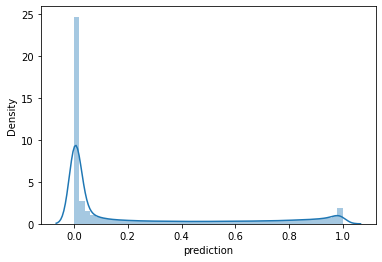

In [19]:
def plot_submission(df):
    sns.distplot(df['prediction'])
    print(df['prediction'].describe())
    print(len(df[df['prediction']>0.95]))
    plt.show()

plot_submission(submission)

In [20]:
# submission['prediction'] *= .99
# submission.to_csv('submission.csv',index=False)